**Extracting Dataset:** 

In [ ]:
!pip install patool

     |████████████████████████████████| 81kB 5.6MB/s 


In [ ]:
import patoolib
patoolib.extract_archive('/content/drive/MyDrive/AI_FinalProject/archive.zip', outdir='/content/drive/MyDrive/AI_FinalProject')

patool: Extracting /content/drive/MyDrive/AI_FinalProject/archive.zip ...
patool: running /usr/bin/7z x -o/content/drive/MyDrive/AI_FinalProject -- /content/drive/MyDrive/AI_FinalProject/archive.zip
patool: ... /content/drive/MyDrive/AI_FinalProject/archive.zip extracted to `/content/drive/MyDrive/AI_FinalProject'.


'/content/drive/MyDrive/AI_FinalProject'

**Imports**:

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import random
from PIL import Image
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

**Data Manipulation:**

In [ ]:
train_dir="/content/drive/MyDrive/AI_FinalProject/sign_data/train"
train_csv="/content/drive/MyDrive/AI_FinalProject/sign_data/train_data.csv"
test_csv="/content/drive/MyDrive/AI_FinalProject/sign_data/test_data.csv"
test_dir="/content/drive/MyDrive/AI_FinalProject/sign_data/test"


In [ ]:
df_train=pd.read_csv(train_csv)
df_train.sample(10)


068/09_068.png  068_forg/03_0113068.PNG  1
7685   009/009_05.PNG  009_forg/0123009_04.png  1
11950  046/11_046.png           046/05_046.png  0
6651   002/002_18.PNG           002/002_22.PNG  0
12570  055/01_055.png           055/06_055.png  0
14687  016/016_18.PNG           016/016_23.PNG  0
19855  041/12_041.png  041_forg/04_0105041.PNG  1
11658  051/12_051.png           051/09_051.png  0
403    033/07_033.png  033_forg/03_0203033.PNG  1
10969  003/003_17.PNG           003/003_06.PNG  0
13528  019/08_019.png  019_forg/03_0115019.PNG  1

In [ ]:
df_test=pd.read_csv(test_csv)
df_test.sample(10)


068/09_068.png  068_forg/03_0113068.PNG  1
776   058/01_058.png           058/05_058.png  0
3001  057/10_057.png  057_forg/02_0210057.PNG  1
1977  055/12_055.png           055/03_055.png  0
3820  054/09_054.png  054_forg/02_0208054.PNG  1
2178  049/02_049.png  049_forg/04_0206049.PNG  1
4850  059/03_059.png           059/11_059.png  0
3442  060/05_060.png           060/07_060.png  0
3775  052/03_052.png           052/08_052.png  0
3731  052/08_052.png           052/01_052.png  0
224   068/06_068.png           068/05_068.png  0

In [ ]:
df_train[4:5]


068/09_068.png  068_forg/03_0113068.PNG  1
4  068/09_068.png  068_forg/04_0113068.PNG  1

In [ ]:
image1_path=os.path.join(train_dir,df_train.iat[4,0])
image1_path


'/content/drive/MyDrive/AI_FinalProject/sign_data/train/068/09_068.png'

**Making Custom Siamese Dataset:**

In [ ]:
class Dataset(Dataset):
    #default constuctor for assigning values
    def __init__(self,train_dir=None,train_csv=None,transform=None):
        self.train_dir=train_dir
        self.train_data=pd.read_csv(train_csv)
        self.train_data.columns=['image1','image2','class']
        self.transform=transform
        
    def __getitem__(self,idx): ## __getitem__ returns a sample data given index, idx=index
        
        img1_path=os.path.join(self.train_dir,self.train_data.iat[idx,0])
        img2_path=os.path.join(self.train_dir,self.train_data.iat[idx,1])
        
        img1=Image.open(img1_path)
        img2=Image.open(img2_path)
        
        img1=img1.convert('L') #L mode image, that means it is a single channel image - normally interpreted as greyscale.
        img2=img2.convert('L')
        
        img1=self.transform(img1)
        img2=self.transform(img2)
        
        return img1, img2, torch.from_numpy(np.array([int(self.train_data.iat[idx,2])],dtype=np.float32))
    
    
    def __len__(self): ## __len__ returns the size of the dataset..
        return len(self.train_data)


In [ ]:
dataset = Dataset(train_dir,train_csv,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))


**Siamese Network:**

In [ ]:
class SiameseNetwork(nn.Module):
    
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        
        self.conv1=nn.Conv2d(1,50,kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
         # L1 ImgIn shape=(?, 28, 28, 1)      # (n-f+2*p/s)+1
        #    Conv     -> (?, 24, 24, 50)
        #    Pool     -> (?, 12, 12, 50)
        
        
        self.conv2 = nn.Conv2d(50,60, kernel_size = 5)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        # L2 ImgIn shape=(?, 12, 12, 50)
        #    Conv      ->(?, 8, 8, 60)
        #    Pool      ->(?, 4, 4, 60)
        
        
        self.conv3 = nn.Conv2d(60, 80,  kernel_size = 3)
        # L3 ImgIn shape=(?, 4, 4, 60)
        #    Conv      ->(?, 2, 2, 80)
       
        
        
        self.batch_norm1 = nn.BatchNorm2d(50)
        self.batch_norm2 = nn.BatchNorm2d(60)
        
#         self.dropout1 = nn.Dropout2d()
        
        # L4 FC 2*2*80 inputs -> 250 outputs
        self.fc1 = nn.Linear(32000, 128) 
        self.fc2 = nn.Linear(128, 2)
        
      
    
    
    def forward1(self,x):
        x=self.conv1(x)
        x = self.batch_norm1(x)
        x=F.relu(x)
        x=self.pool1(x)
        
        x=self.conv2(x)
        x = self.batch_norm2(x)
        x=F.relu(x)
        x=self.pool2(x)
        
        x=self.conv3(x)
        x=F.relu(x)
#         print(x.size())
        x = x.view(x.size()[0], -1)
#         print('Output2')
#         print(x.size()) #32000 thats why the input of fully connected layer is 32000
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward1(input1)
        # forward pass of input 2
        output2 = self.forward1(input2)
        
        return output1, output2

**Loss Function:**

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=1.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive


In [ ]:
train_dataloader = DataLoader(dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=32)


In [ ]:
train_dataloader


In [ ]:
if torch.cuda.is_available():
    print('Yes')


Yes


In [ ]:
net = SiameseNetwork().cuda()

criterion = ContrastiveLoss()               
optimizer = torch.optim.SGD(net.parameters(), lr = 3e-4) 

optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99)

**Training:**

In [ ]:
def train():
    loss= [] 

    for epoch in range(1,10):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            
        print("Epoch {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))

        loss.append(loss_contrastive.item())
        
    return net


In [ ]:
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")


Epoch 1
 Current loss 0.5973383784294128

Epoch 2
 Current loss 0.44815489649772644

Epoch 3
 Current loss 0.6113184690475464

Epoch 4
 Current loss 0.7114297151565552

Epoch 5
 Current loss 0.7607284188270569

Epoch 6
 Current loss 0.6217803955078125

Epoch 7
 Current loss 0.5932032465934753

Epoch 8
 Current loss 0.5838832855224609



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [ ]:
test_dataset = Dataset(test_dir,test_csv,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))

test_dataloader = DataLoader(test_dataset,num_workers=8,batch_size=1,shuffle=True)


In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

**Testing the model by comparing the model's distance prediction:**

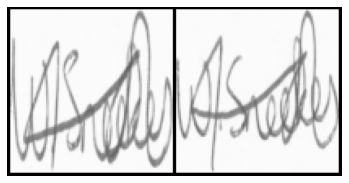

Predicted Eucledian Distance:- 1.1151236295700073
Actual Label:- Original Pair Of Signature


Predicted Eucledian Distance:- 0.5636888742446899
Actual Label:- Forged Pair Of Signature


Predicted Eucledian Distance:- 0.9963951110839844
Actual Label:- Original Pair Of Signature


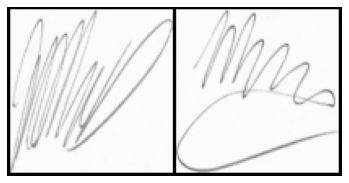

Predicted Eucledian Distance:- 1.3249659538269043
Actual Label:- Forged Pair Of Signature


Predicted Eucledian Distance:- 0.34750792384147644
Actual Label:- Forged Pair Of Signature


Predicted Eucledian Distance:- 0.6844640374183655
Actual Label:- Forged Pair Of Signature


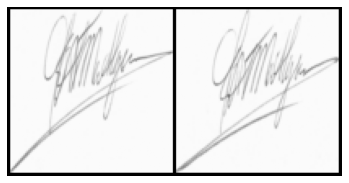

Predicted Eucledian Distance:- 0.508415162563324
Actual Label:- Original Pair Of Signature


Predicted Eucledian Distance:- 0.792439877986908
Actual Label:- Forged Pair Of Signature


Predicted Eucledian Distance:- 0.6735236048698425
Actual Label:- Forged Pair Of Signature


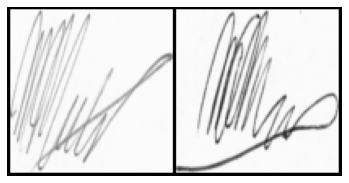

Predicted Eucledian Distance:- 0.4849563241004944
Actual Label:- Forged Pair Of Signature


In [ ]:
count=0
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concat = torch.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))

  eucledian_distance = F.pairwise_distance(output1, output2)
    
  if label==torch.FloatTensor([[0]]):
    label="Original Pair Of Signature"
  else:
    label="Forged Pair Of Signature"
    
  imshow(torchvision.utils.make_grid(concat))
  print("Predicted Eucledian Distance:-",eucledian_distance.item())
  print("Actual Label:-",label)
  count=count+1
  if count ==10:
     break

Model predicts distances quite well. 